# Homework 5

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - You can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope.

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:** Alex
+ **Last Name:** Shank
+ **Email:** shank14@purdue.edu

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
import scipy.stats as st
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file, putting it in your Google drive, mounting the drive, and changing to the directory of the file (see Problem 0 in [Homework](https://colab.research.google.com/github/PredictiveScienceLab/data-analytics-se/blob/master/homework/homework_03.ipynb); or
+ Downloading the file to the working directory of this notebook with this code:

In [2]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt'
# download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [3]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force they marked the stress (force be unit area) in the middle of the materail and the corresponding strain of the material (percent enlogation in the pulling direction).
- Eventually the material entered the plastic regime and then it broke.
Here is a visualization of the data:

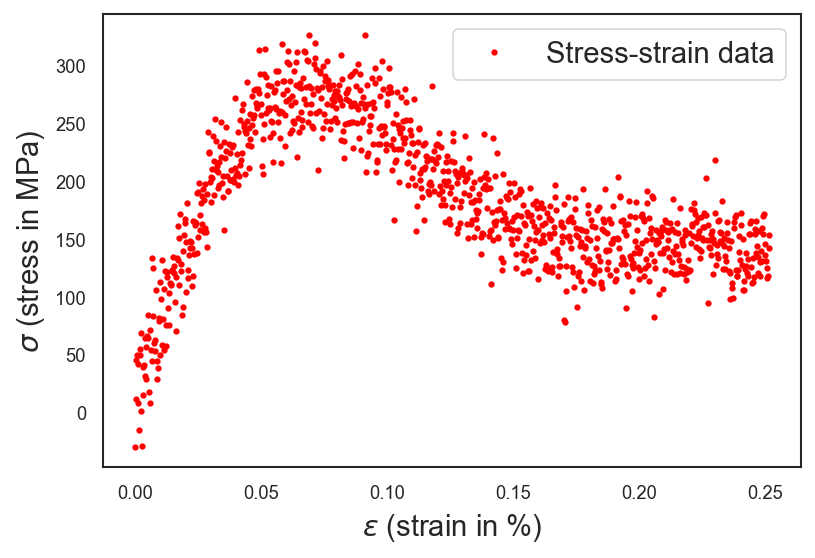

In [4]:
x = data[:, 0] # Strain 
y = data[:, 1] # Stress in MPa
plt.figure(dpi=150)
plt.plot(x, y, 'ro', markersize=2, label = 'Stress-strain data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14)

Note that for each particular value of the strain, you don't necessarily get a unique stress.
This is because in molecular dynamics the atoms are jiggling around due to thermal effects.
So there is always this "jiggling" noise when you are trying to measure the stress and the strain.
We would like to process this noise in order to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the the material which is affeted by the fine structure, e.g., the chemical bonds, the crystaline structure, any defects, etc.
It is a required input to mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:
$$
\sigma(\epsilon) = E\epsilon.
$$
The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without any noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

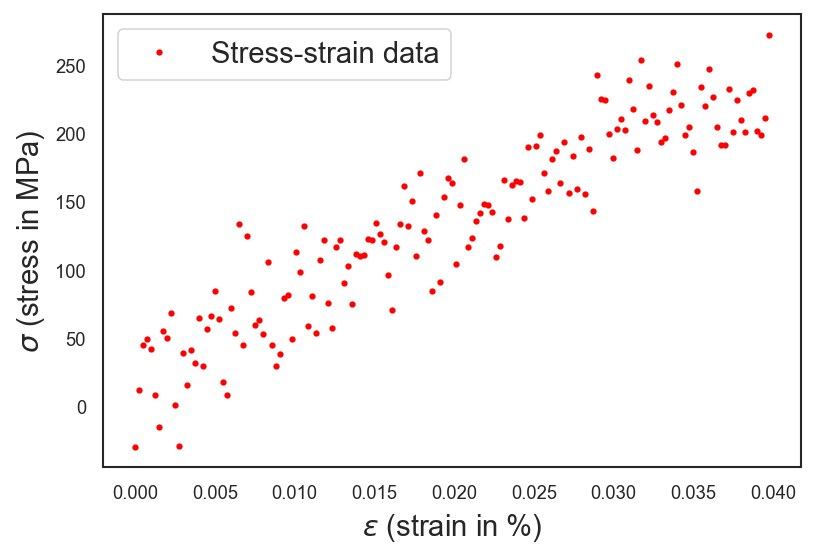

In [5]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]
# Visualize to make sure you have the right data
plt.figure(dpi=150)
plt.plot(x_rel, y_rel, 'ro', markersize=2, label = 'Stress-strain data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

Split your data into training and validation. Hint: You may use [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html](sklearn.model_selection.train_test_split) if you wish.

In [6]:
# Split the data into training and validation datasets
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_rel, y_rel, test_size=0.5, shuffle=True)

Use the following to visualize your split:

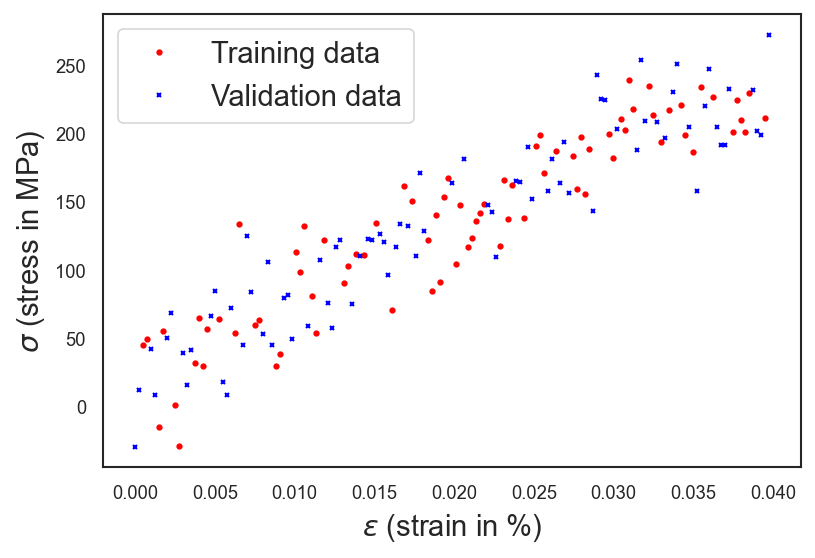

In [7]:
# Your code to plot the two datasets here
plt.figure(dpi=150)
plt.plot(x_train, y_train, 'ro', markersize=2, label = 'Training data')
plt.plot(x_valid, y_valid, 'bx', markersize=2, label = 'Validation data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [8]:
# Load the Bayesian linear regression class:
from sklearn.linear_model import BayesianRidge

# Build the design matrix (only using a single feature)
Phi = x_train.reshape(-1, 1)
model = BayesianRidge(normalize=True, fit_intercept=False).fit(Phi, y_train)

In [9]:
sigma = np.sqrt(1.0 / model.alpha_)
print('Noise variance            -> sigma = {0:1.2f} MPa'.format(sigma))

alpha = model.lambda_
print('Hyperparameters for prior -> alpha = {}'.format(alpha))

Noise variance            -> sigma = 28.87 MPa
Hyperparameters for prior -> alpha = 2.433126818092288e-08


### Subpart A.III
Calculate the mean square error of the validation data.

In [10]:
Phi_valid = x_valid
Phi_valid = x_valid.reshape(-1, 1)
y_valid_pred_mean, y_valid_pred_std = model.predict(Phi_valid, return_std=True)

mse = sum(np.square(y_valid_pred_mean - y_valid)) / len(y_valid)
print('Mean squared error from validation dataset -> MSE = {} MPa'.format(mse))

Mean squared error from validation dataset -> MSE = 914.7468455932878 MPa


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

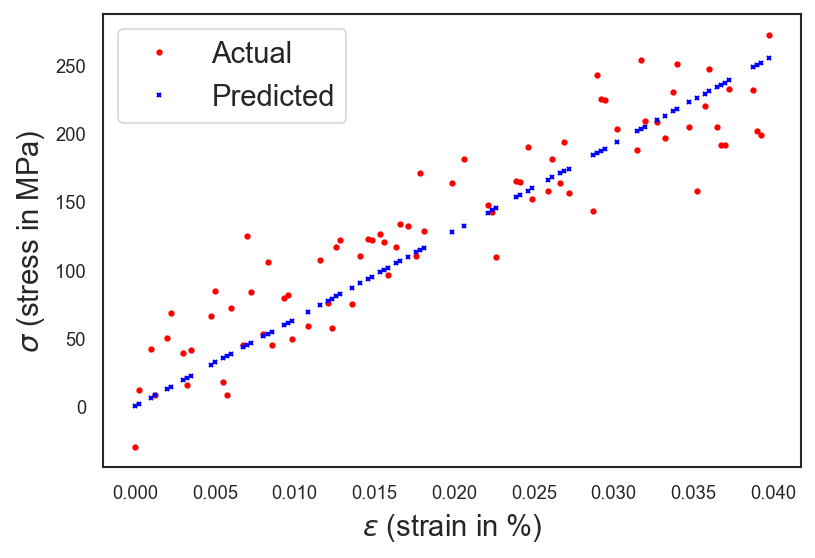

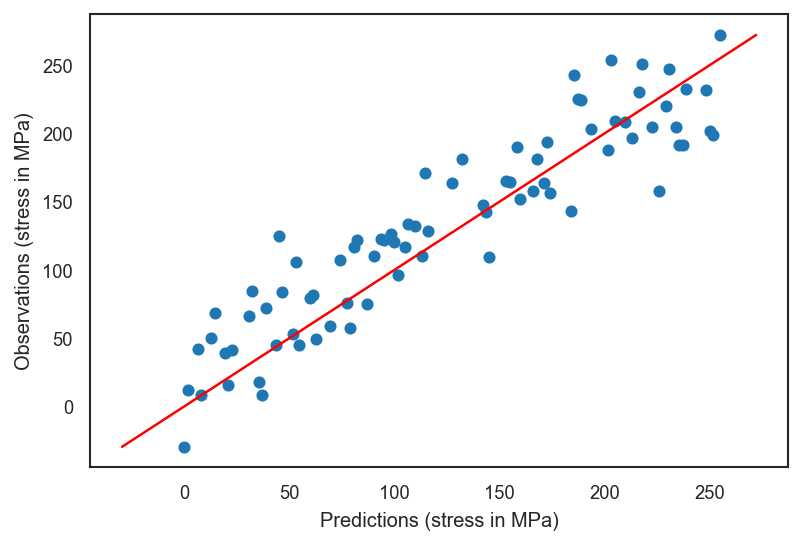

In [12]:
plt.figure(dpi=150)
plt.plot(x_valid, y_valid, 'ro', markersize=2, label = 'Actual')
plt.plot(x_valid, y_valid_pred_mean, 'bx', markersize=2, label = 'Predicted')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

fig, ax = plt.subplots(dpi=150)
ax.plot(y_valid_pred_mean, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions (stress in MPa)')
ax.set_ylabel('Observations (stress in MPa)');

### Subpart A.V
Compute and plot the standarized errors for the validation data.

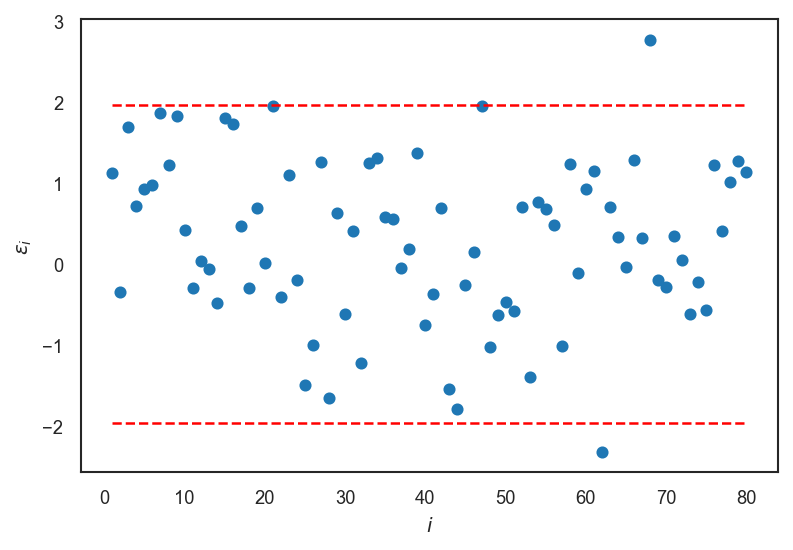

In [13]:
# The standarized errors
standardized_errors = (y_valid - y_valid_pred_mean) / y_valid_pred_std
i = np.arange(1, standardized_errors.shape[0] + 1)
fig, ax = plt.subplots(dpi=150)
ax.plot(i, standardized_errors, 'o', label='Standarized errors')
# The 97.5% quantile of the normal as a red dashed line
ax.plot(i, 1.96 * np.ones(standardized_errors.shape[0]), 'r--')
# The 2.5% quantile of the normal as a red dashed line
ax.plot(i, -1.96 * np.ones(standardized_errors.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

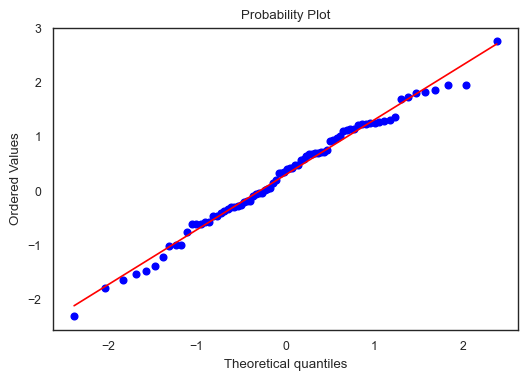

In [14]:
fig, ax = plt.subplots(dpi=100)
st.probplot(standardized_errors, dist=st.norm, plot=ax);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

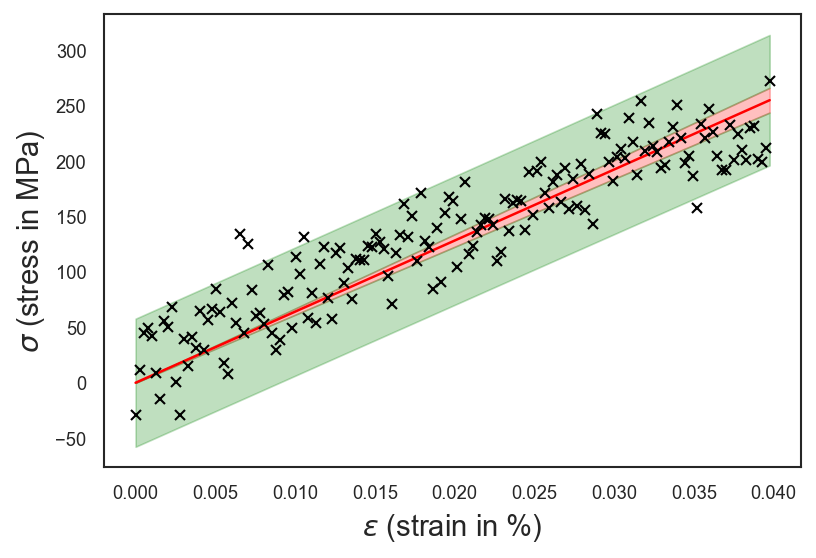

In [15]:
xx = np.linspace(0, x_rel.max(), 100)
Phi_xx = xx
Phi_xx = Phi_xx.reshape(-1, 1)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x_rel, y_rel, 'kx', label='Observed data')
ax.set_xlabel('$\epsilon$ (strain in %)', fontsize=14)
ax.set_ylabel('$\sigma$ (stress in MPa)', fontsize=14);

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

In [16]:
# The posterior of the weights as a distribution:
mean_post = model.coef_.item() # posterior mean
print(mean_post)
S_post = model.sigma_.item()   # posterior covariance
print(S_post)
E_post = st.norm(loc=mean_post, scale=np.sqrt(S_post))

6409.3522503790555
19664.414822037306


Text(0, 0.5, '$p(\\mathbf{E}|x_{1:N}, y_{1:N})$')

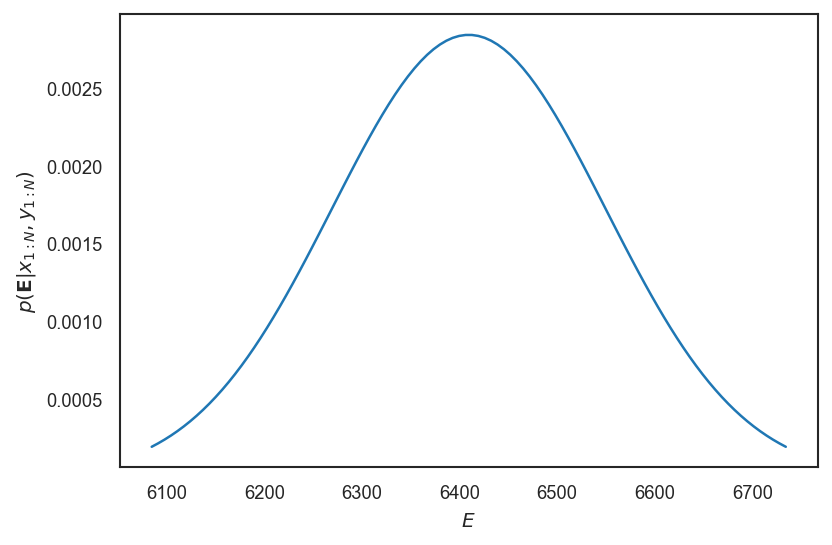

In [17]:
fig, ax = plt.subplots(dpi=150)
e_025 = E_post.ppf(0.025)
e_975 = E_post.ppf(0.975)
es = np.linspace(e_025 - 50, e_975 + 50, 100)
ax.plot(es, E_post.pdf(es))
ax.set_xlabel('$E$')
ax.set_ylabel('$p(\mathbf{E}|x_{1:N}, y_{1:N})$')

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

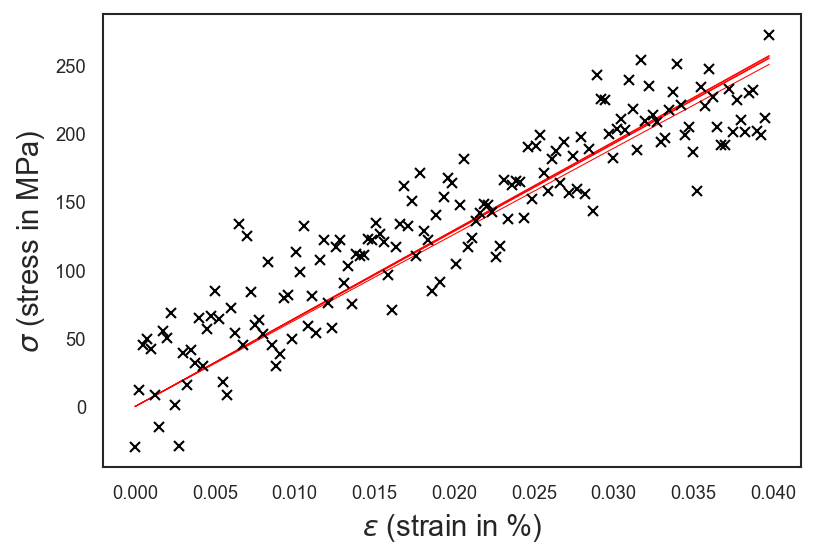

In [18]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
for _ in range(5):
    E_sample = E_post.rvs()
    yy_sample = np.dot(Phi_xx, E_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
    
# plot the data again
ax.plot(x_rel, y_rel, 'kx', label='Observed data')

ax.set_xlabel('$\epsilon$ (strain in %)', fontsize=14)
ax.set_ylabel('$\sigma$ (stress in MPa)', fontsize=14);

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

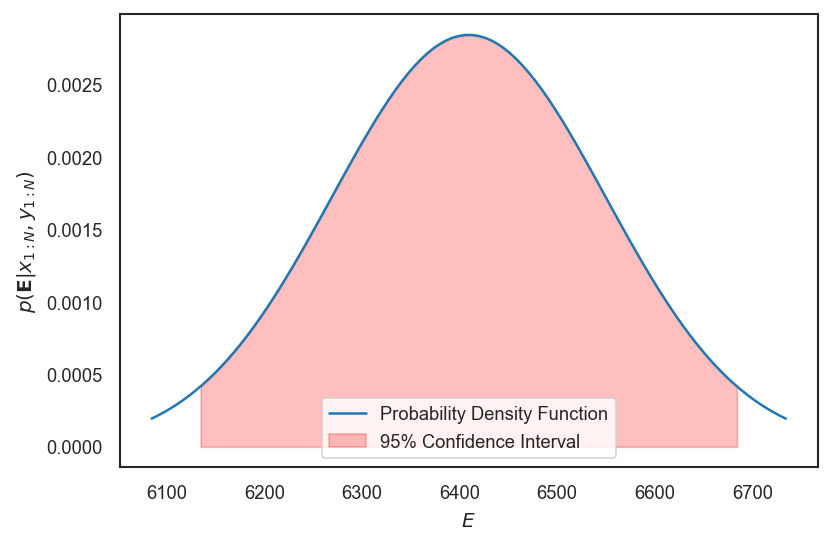

In [19]:
fig, ax = plt.subplots(dpi=150)
es_centered = np.linspace(e_025, e_975, 100)
ax.plot(es, E_post.pdf(es), label="Probability Density Function")
ax.fill_between(es_centered, np.zeros(es_centered.shape[0]), E_post.pdf(es_centered), color='red', alpha=0.25, label="95% Confidence Interval")
ax.set_xlabel('$E$')
ax.set_ylabel('$p(\mathbf{E}|x_{1:N}, y_{1:N})$')
plt.legend(loc='best');

### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [20]:
peak_probability = es[np.argmax(E_post.pdf(es))]
print('Peak probability of Young modulus E = {0:1.2f} N/m^2'.format(peak_probability))

Peak probability of Young modulus E = 6406.07 N/m^2


**The peak of the posterior density function of E occurs at approximately 6532.76 N/m^2, so this is a reasonable single value to pick for E.**

## Part B - Estimate the ultimate strength

The peak of the stress-strain curve is known as the ultimate strength.
We will like to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.5, shuffle=True)

Use the following to visualize your split:

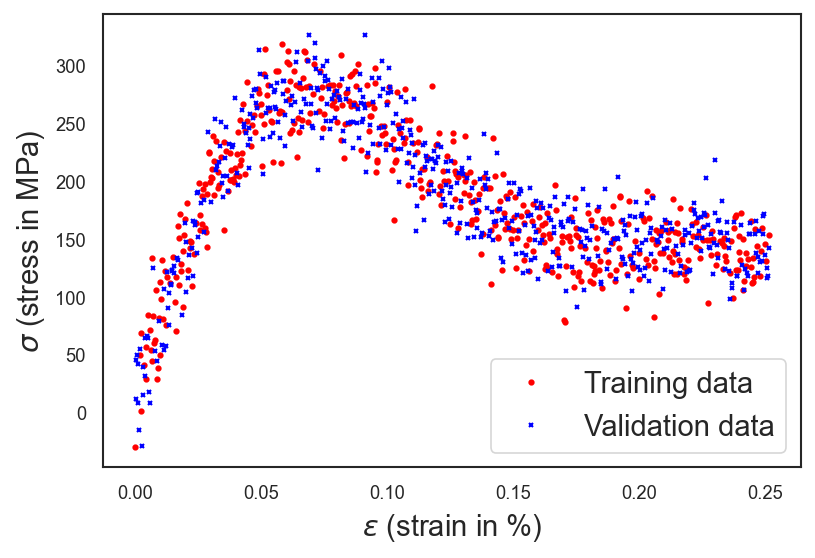

In [23]:
plt.figure(dpi=150)
plt.plot(x_train, y_train, 'ro', markersize=2, label = 'Training data')
plt.plot(x_valid, y_valid, 'bx', markersize=2, label = 'Validation data')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model that can capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ it is linear in the parameters to be estimated,
+ it clearly has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We are goint to use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:
$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$
where
$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$
and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:
$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:
$$
\begin{split}
f(\epsilon) &= 
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$
We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:
$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$
The reason we include the first derivative is so that we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:
$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$
We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:
$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$
We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other parameters.
I am going to spare you the details...
The end result is:
$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$
Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [24]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """
    Computes the design matrix for the stress-strain curve problem.
    
    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon
    for i in range(2, d+1):
        Phi[:, i-1] = ((i - 1) * epsilon_l**i - i*Epsilon*epsilon_l**(i-1) + Epsilon**i) * Step
    return Phi

Visualize the basis functions here:

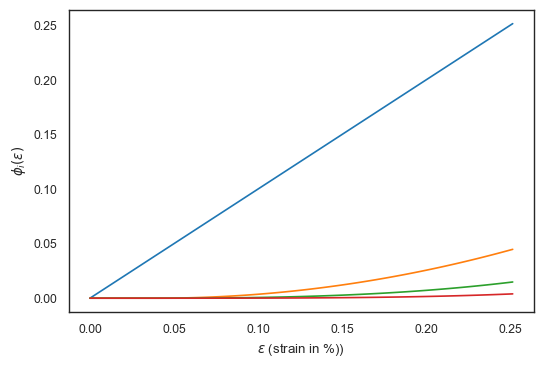

In [25]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$');

### Subpart B.III 

Fit the model using automatic relevance determination and demonstrate that it works well by doing all the things we did above (MSE, observations vs predictions plot, standarized errors, etc.).

In [26]:
from sklearn.linear_model import ARDRegression
# Do not normalize. ARDRegression seems to have a bug when you do.
Phi = compute_design_matrix(x_train, epsilon_l, d)
model = ARDRegression(normalize=False, fit_intercept=False, threshold_lambda=np.inf).fit(Phi, y_train)

Noise variance and hyperparameter values

In [27]:
sigma = np.sqrt(1.0 / model.alpha_)
print('Noise variance            -> sigma = {0:1.2f} MPa'.format(sigma))

alpha = model.lambda_
print('Hyperparameters for prior -> alphas = {}'.format(alpha))

Noise variance            -> sigma = 27.29 MPa
Hyperparameters for prior -> alphas = [3.37765418e-08 1.70689969e-11 7.96288013e-13 3.13529737e-13]


MSE from validation dataset

In [28]:
Phi_valid = compute_design_matrix(x_valid, epsilon_l, d)
y_valid_pred_mean, y_valid_pred_std = model.predict(Phi_valid, return_std=True)

mse = sum(np.square(y_valid_pred_mean - y_valid)) / len(y_valid)
print('Mean squared error from validation dataset -> MSE = {} MPa'.format(mse))

Mean squared error from validation dataset -> MSE = 700.8588270097652 MPa


Precisions corresponding to each weight

Text(0.5, 1.0, '$N=500$')

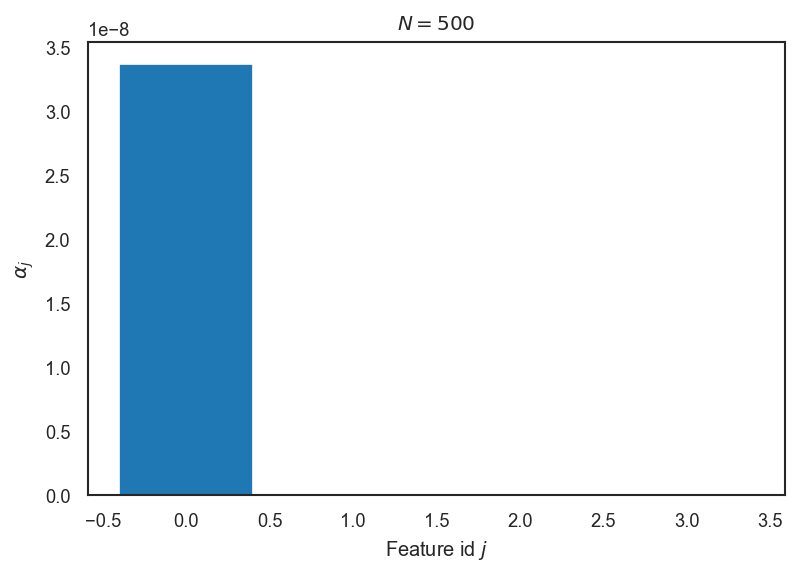

In [29]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(len(alpha)), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(len(x_train)))

**All of our precision values are close to zero.** The first precision is magnitudes larger than the others, so we could try our model without the first term. We will just leave it in though, to show we did our due dilegence reviewing the diagonstics.

Observations versus predictions plots

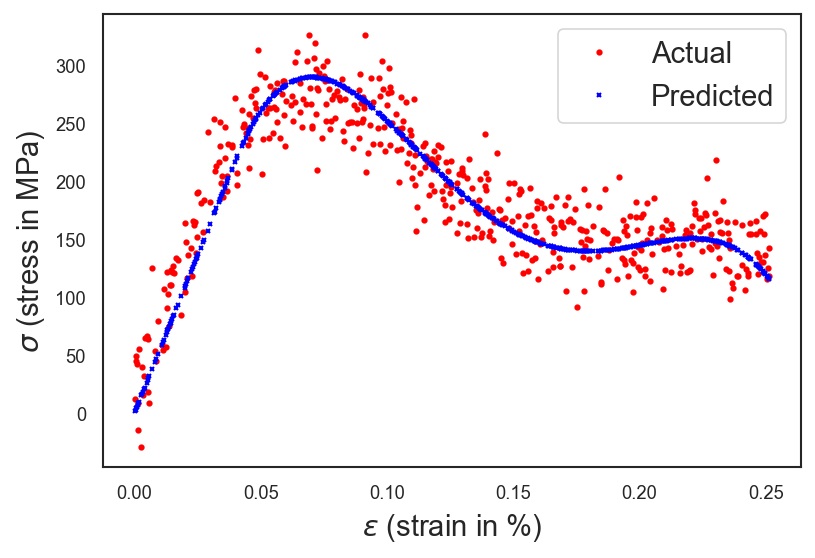

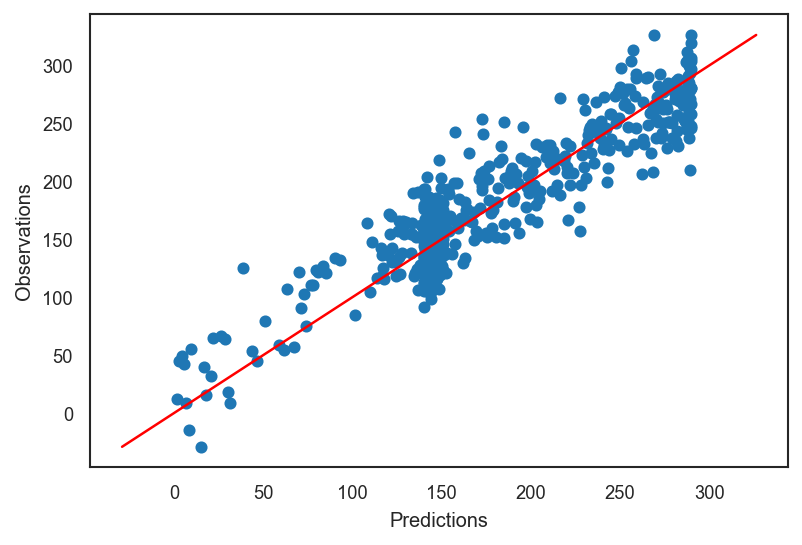

In [30]:
plt.figure(dpi=150)
plt.plot(x_valid, y_valid, 'ro', markersize=2, label = 'Actual')
plt.plot(x_valid, y_valid_pred_mean, 'bx', markersize=2, label = 'Predicted')
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

fig, ax = plt.subplots(dpi=150)
ax.plot(y_valid_pred_mean, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

Compute standardized errors and plot them.

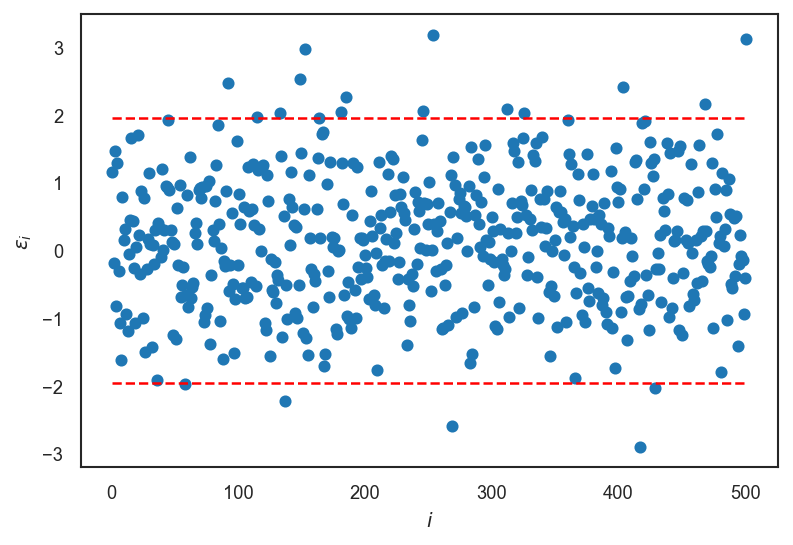

In [31]:
# your code here
standardized_errors = (y_valid - y_valid_pred_mean) / y_valid_pred_std

fig, ax = plt.subplots(dpi=150)
i = np.arange(1, standardized_errors.shape[0] + 1)
# The standarized errors
ax.plot(i, standardized_errors, 'o', label='Standarized errors')
# The 97.5% quantile of the normal as a red dashed line
ax.plot(i, 1.96 * np.ones(standardized_errors.shape[0]), 'r--')
# The 2.5% quantile of the normal as a red dashed line
ax.plot(i, -1.96 * np.ones(standardized_errors.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

Quantile-quantile plot of the standardized errors.

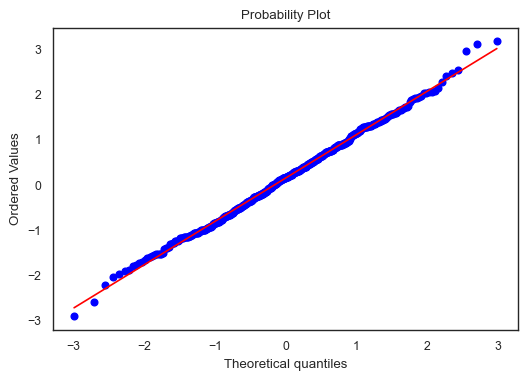

In [32]:
fig, ax = plt.subplots(dpi=100)
st.probplot(standardized_errors, dist=st.norm, plot=ax);

### Subpart B.IV
Visualize epistemic and aleatory uncertainty in the stess-strain relation.

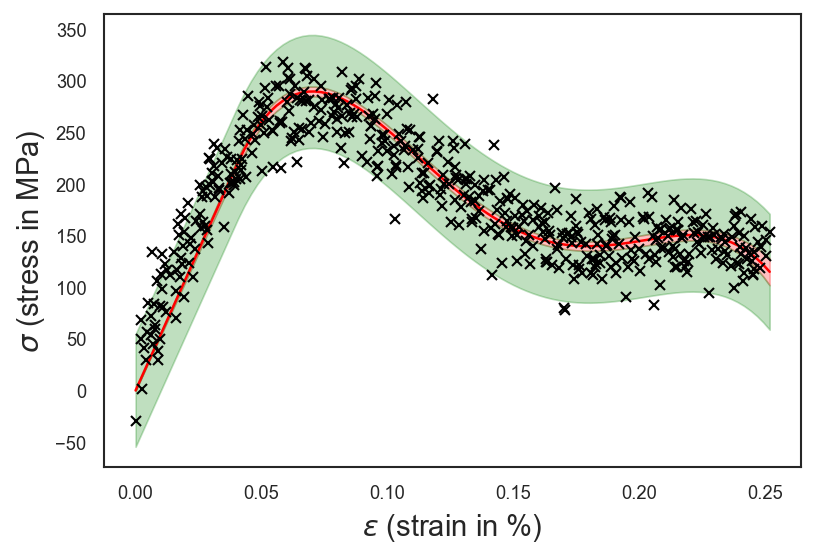

In [33]:
xx = np.linspace(0, x.max(), 100)
Phi_xx = compute_design_matrix(xx, epsilon_l, d)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x_train, y_train, 'kx', label='Observed data')
ax.set_xlabel('$\epsilon$ (strain in %)', fontsize=14)
ax.set_ylabel('$\sigma$ (stress in MPa)', fontsize=14);

### Subpart B.V - Extract the ultimate strength

Now, you are going to quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
    + sample from the posterior of the weights of your model
    + for each sample evaluate the stresses at the dense set of strain points defined earlier
    + for each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

In [34]:
mean_post = model.coef_ # posterior mean
S_post = model.sigma_   # posterior covariance
w_post = st.multivariate_normal(mean=mean_post, cov=S_post)
print(w_post.rvs())

[    5506.29673835  -249873.53986832  1160245.08081778 -1850422.54395566]


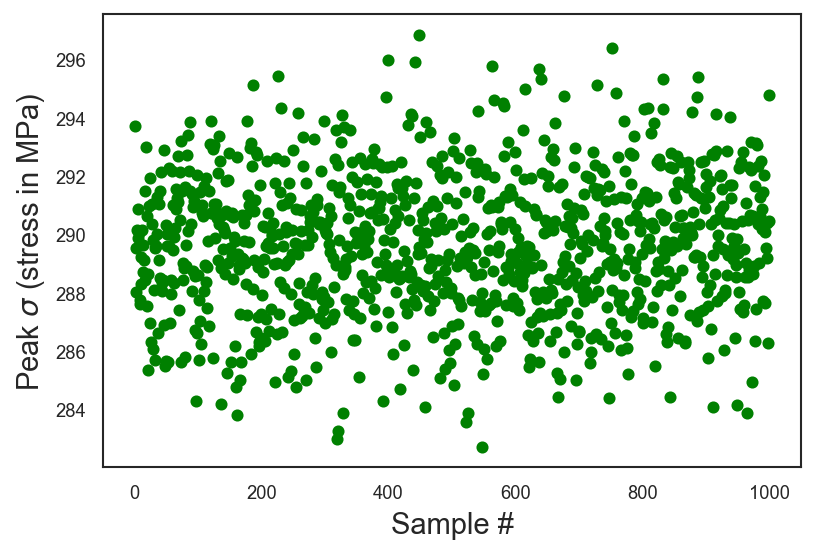

In [35]:
xs = np.linspace(0, 0.25, 1000)
Phi_xs = compute_design_matrix(xs, epsilon_l, d)
fig, ax = plt.subplots(dpi=150)
num_samples = 1000
sample_peaks = np.ndarray((num_samples,))
for i in range(num_samples):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xs, w_sample)
    sample_peaks[i] = np.max(yy_sample)
    
# plot the data again
ax.plot(np.arange(1, num_samples + 1), sample_peaks, 'go', label='Sample Max')

ax.set_xlabel('Sample #', fontsize=14)
ax.set_ylabel('Peak $\sigma$ (stress in MPa)', fontsize=14);

Check that the samples look normally distributed, then we can get the 95% centered credible interval easily.

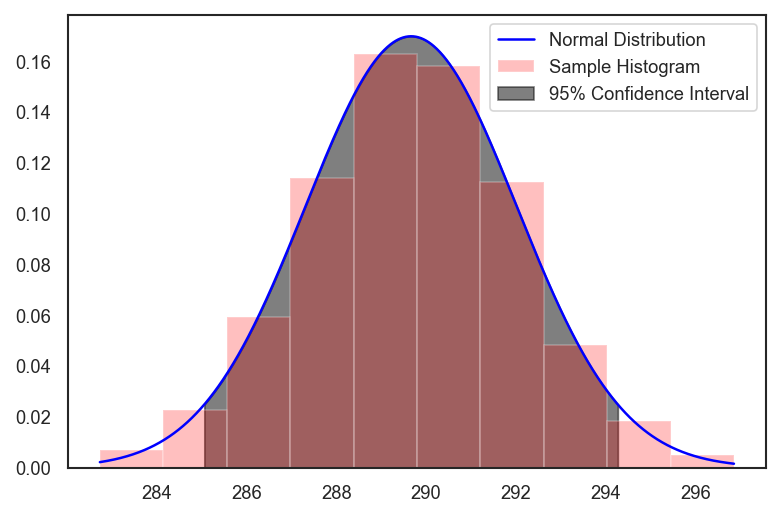

In [77]:
fig, ax = plt.subplots(dpi=150)
ax.hist(sample_peaks, alpha=0.25, density=True, color='red', label="Sample Histogram")

peak_xs = np.linspace (np.min(sample_peaks), np.max(sample_peaks), 1000)
peak_mean = np.mean(sample_peaks)
peak_std = np.std(sample_peaks)
theoretical_distribution = st.norm(loc=peak_mean, scale=peak_std)
ax.plot(peak_xs, theoretical_distribution.pdf(peak_xs), 'b', label="Normal Distribution")

interval_start = theoretical_distribution.ppf(0.025)
interval_end = theoretical_distribution.ppf(0.975)
interval_xs = np.linspace(interval_start, interval_end, 1000)
ax.fill_between(interval_xs, np.zeros(interval_xs.shape[0]), theoretical_distribution.pdf(interval_xs), color='black', alpha=0.5, label="95% Confidence Interval")

plt.legend(loc='best')

In [37]:
print('95% centered credible interval is the range   -> start, end = {}, {} MPa'.format(theoretical_distribution.ppf(0.025), theoretical_distribution.ppf(0.975)))
print('A reasonable choice for the ultimate strength -> mean       = {} MPa'.format(np.mean(sample_peaks)))


95% centered credible interval is the range   -> start, end = 285.05885752540854, 294.2678038563608 MPa
A reasonable choice for the ultimate strength -> mean       = 289.66333069088466 MPa


# Problem 2 - Optimizing the performance of a compressor

In this problem we are going to need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google drive or just download it with the code segment below:

In [38]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx'
# download(url)

Note that this is an Excell file, so we are going to need pandas to read it.
Here is how:

In [39]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of a an experimental study of a variable speed reciprocating compressor.
The experimentalists varied two temperatures $T_e$ and $T_c$ (both in C) and they measured various other quantities.
Our goal is to learn the map between $T_e$ and $T_c$ and measured Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [42]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
# x

In [43]:
# Here is how to extract the Capacity
y = data['Capacity'].values
# y

Fit the following multivariate polynomial model to **both the Capacity and the Power**:
$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$
where $\epsilon$ is a Gaussian noise term with unknown variance.
**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to make sure that your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the capacity

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [44]:
# split data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.7, shuffle=True)

# create polynomial design matrix
from sklearn.preprocessing import PolynomialFeatures
Phi_train = PolynomialFeatures(degree = 3).fit_transform(x_train)

# create model
model = ARDRegression(normalize=False, fit_intercept=False, threshold_lambda=np.inf).fit(Phi_train, y_train)

Noise variance and hyperparameter values

In [45]:
sigma = np.sqrt(1.0 / model.alpha_)
print('Noise variance            -> sigma = {0:1.2f} W'.format(sigma))

alpha = model.lambda_
print('Hyperparameters for prior -> alphas = {}'.format(alpha))

Noise variance            -> sigma = 0.31 W
Hyperparameters for prior -> alphas = [4.30415426e-09 3.03556563e-06 3.48019706e-05 1.82567752e-02
 1.13658077e-01 1.70667256e+02 1.54167248e+03 5.71002739e+02
 1.25577491e+03 1.63459451e+05]


MSE from validation dataset

In [46]:
Phi_valid = PolynomialFeatures(degree = 3).fit_transform(x_valid)
y_valid_pred_mean, y_valid_pred_std = model.predict(Phi_valid, return_std=True)

mse = sum(np.square(y_valid_pred_mean - y_valid)) / len(y_valid)
print('Mean squared error from validation dataset -> MSE = {} W'.format(mse))

Mean squared error from validation dataset -> MSE = 0.19447886250111185 W


Precision corresponding to each weight

Text(0.5, 1.0, '$N=19$')

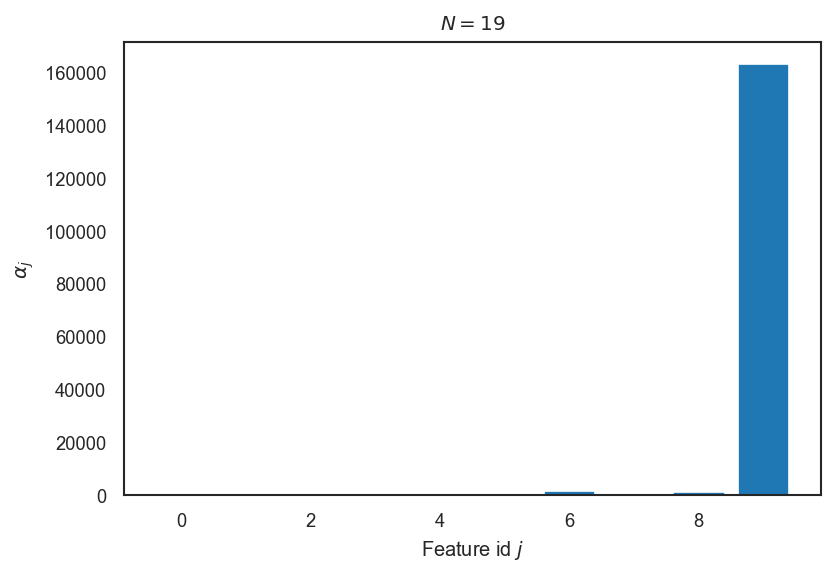

In [47]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(len(alpha)), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(len(x_train)))

**We can see from the above plot that we do not need the 6th, 8th, or 9th degree terms of our polynomial.** We'll just keep them to show we did our due dilligence reviewing the diagonstics.

Observations versus predictions plots

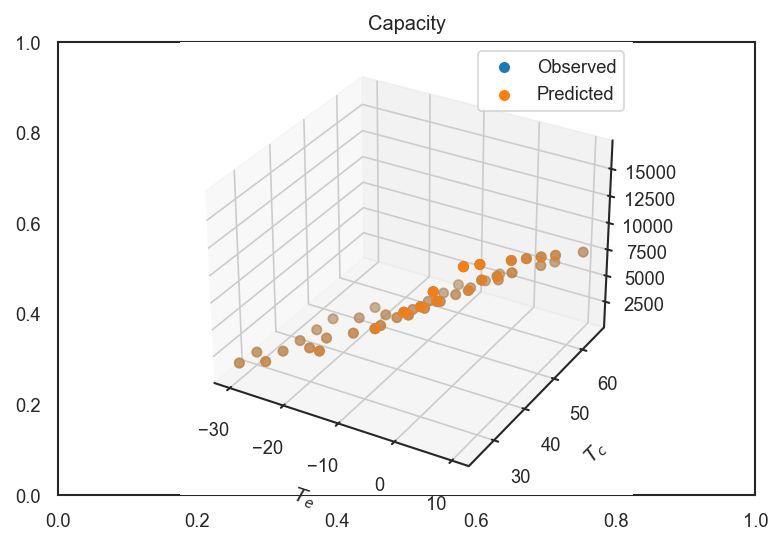

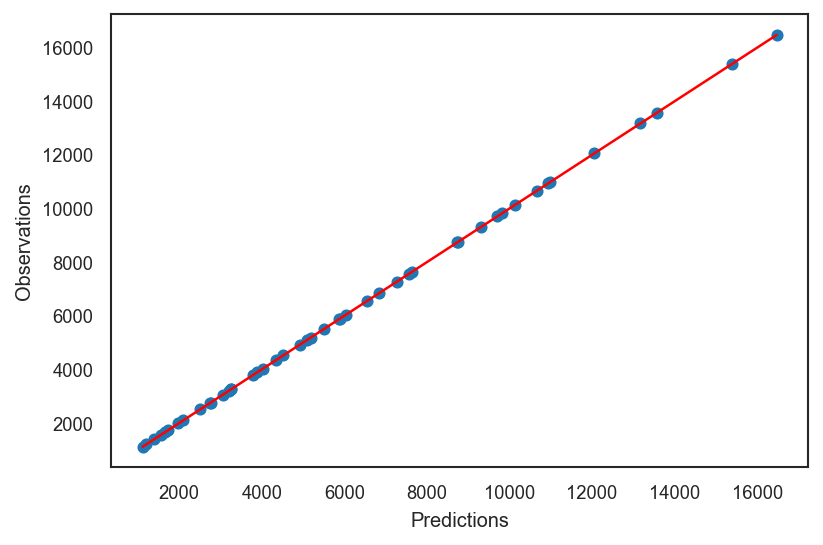

In [48]:
fig, ax = plt.subplots(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('$T_e$')
ax.set_ylabel('$T_c$')
ax.set_title('Capacity')
ax.scatter(x_valid[:,0], x_valid[:,1], y_valid, label='Observed')
ax.scatter(x_valid[:,0], x_valid[:,1], y_valid_pred_mean, label='Predicted')
plt.legend(loc='best')

fig, ax = plt.subplots(dpi=150)
ax.plot(y_valid_pred_mean, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

Compute standardized errors and plot them.

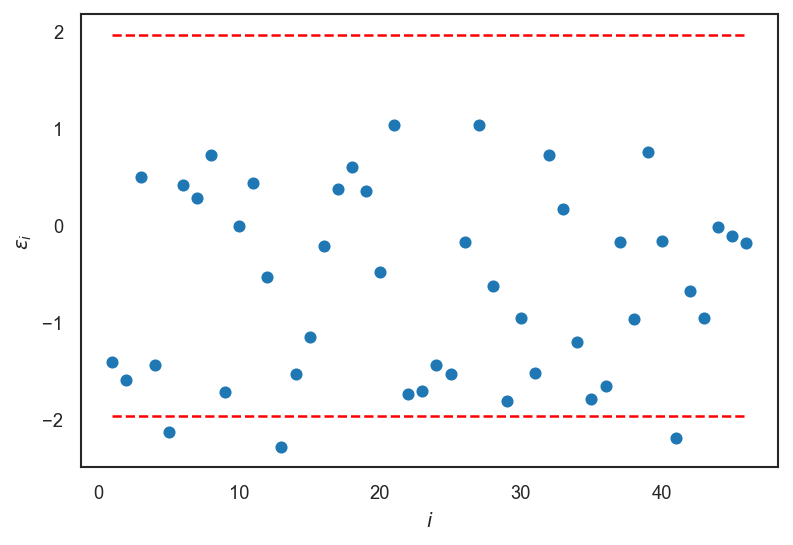

In [49]:
standardized_errors = (y_valid - y_valid_pred_mean) / y_valid_pred_std

fig, ax = plt.subplots(dpi=150)
i = np.arange(1, standardized_errors.shape[0] + 1)
# The standarized errors
ax.plot(i, standardized_errors, 'o', label='Standarized errors')
# The 97.5% quantile of the normal as a red dashed line
ax.plot(i, 1.96 * np.ones(standardized_errors.shape[0]), 'r--')
# The 2.5% quantile of the normal as a red dashed line
ax.plot(i, -1.96 * np.ones(standardized_errors.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

Quantile-quantile plot of the standardized errors.

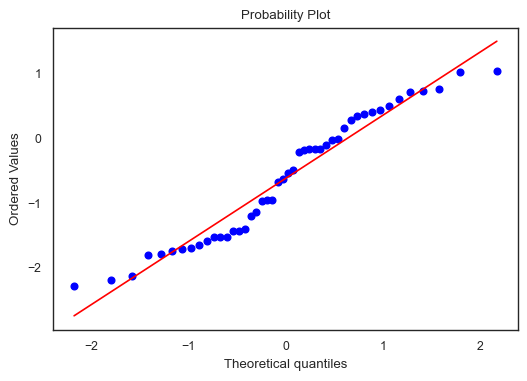

In [50]:
fig, ax = plt.subplots(dpi=100)
st.probplot(standardized_errors, dist=st.norm, plot=ax);

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [51]:
sigma = np.sqrt(1.0 / model.alpha_)
print('Noise variance            -> sigma = {0:1.2f} W'.format(sigma))

Noise variance            -> sigma = 0.31 W


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

**If you look at the precision plot shown in the diagnostics above, you can see that the 6th, 8th, and 9th degree terms of the polynomial are not very important.** All the other terms in the polynomial are therefore important, because they have small precision values corresponding to their respective weights.

### Subpart B.I - Fit the Power

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [52]:
y = data['Power'].values

# split data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.7, shuffle=True)

# create polynomial design matrix
from sklearn.preprocessing import PolynomialFeatures
Phi_train = PolynomialFeatures(degree = 3).fit_transform(x_train)

# create model
model = ARDRegression(normalize=False, fit_intercept=False, threshold_lambda=np.inf).fit(Phi_train, y_train)


Noise variance and hyperparameter values

In [53]:
sigma = np.sqrt(1.0 / model.alpha_)
print('Noise variance            -> sigma = {0:1.2f} W'.format(sigma))

alpha = model.lambda_
print('Hyperparameters for prior -> alphas = {}'.format(alpha))

Noise variance            -> sigma = 16.26 W
Hyperparameters for prior -> alphas = [2.09763572e-06 8.09810634e-02 6.00699618e-04 2.77891507e+00
 4.42302348e+03 2.42248890e+03 1.45703583e+05 1.27322687e+05
 3.31321789e+03 1.06908708e+05]



MSE from validation dataset

In [54]:

Phi_valid = PolynomialFeatures(degree = 3).fit_transform(x_valid)
y_valid_pred_mean, y_valid_pred_std = model.predict(Phi_valid, return_std=True)

mse = sum(np.square(y_valid_pred_mean - y_valid)) / len(y_valid)
print('Mean squared error from validation dataset -> MSE = {} W'.format(mse))

Mean squared error from validation dataset -> MSE = 2954.530776359473 W



Precision corresponding to each weight

Text(0.5, 1.0, '$N=19$')

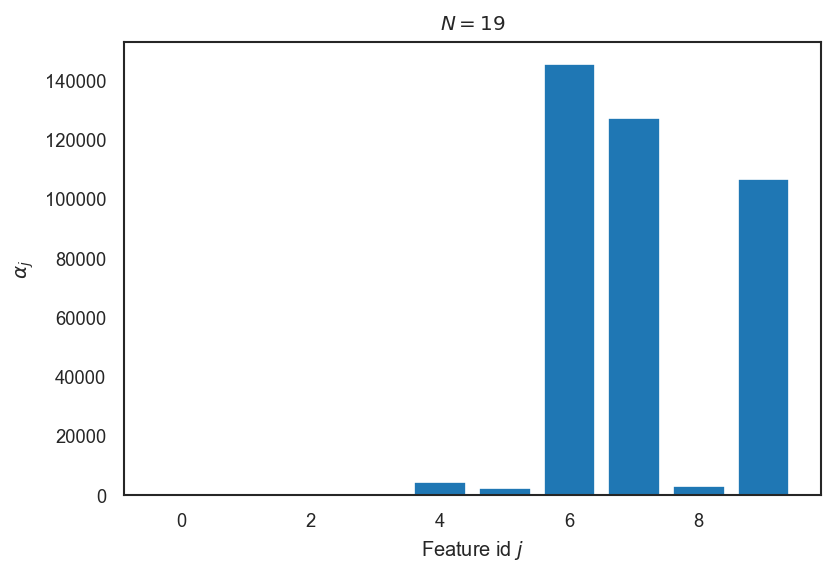

In [55]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(len(alpha)), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(len(x_train)))


**We can see from the above plot that we do not need the 4th through 9th degree terms of our polynomial.** We'll just keep them to show we did our due dilligence reviewing the diagonstics.


Observations versus predictions plots

Text(0, 0.5, 'Observations')

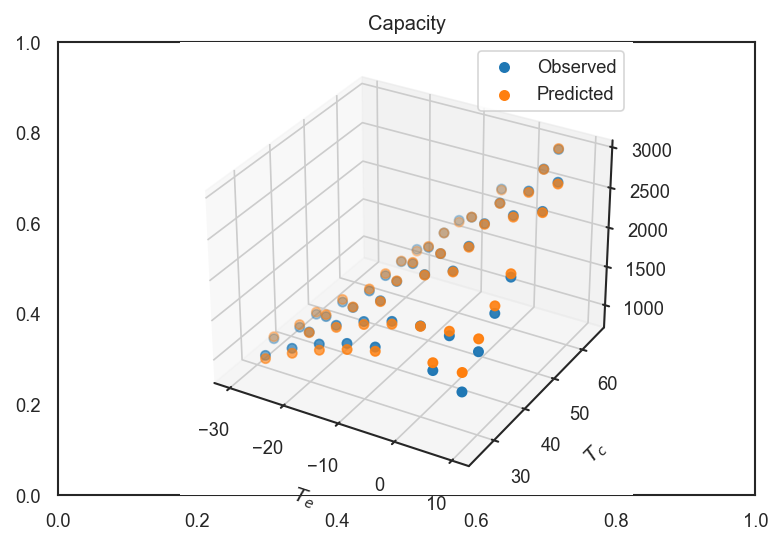

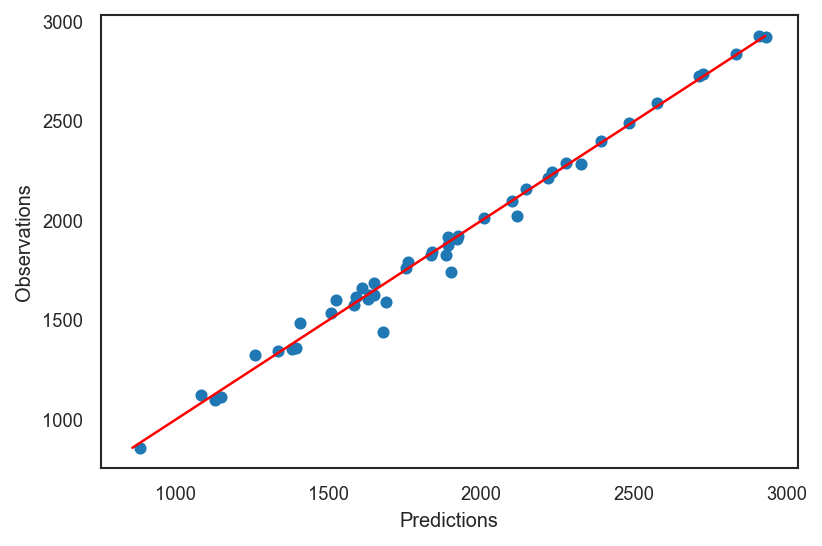

In [56]:
fig, ax = plt.subplots(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('$T_e$')
ax.set_ylabel('$T_c$')
ax.set_title('Capacity')
ax.scatter(x_valid[:,0], x_valid[:,1], y_valid, label='Observed')
ax.scatter(x_valid[:,0], x_valid[:,1], y_valid_pred_mean, label='Predicted')
plt.legend(loc='best')

fig, ax = plt.subplots(dpi=150)
ax.plot(y_valid_pred_mean, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')

Compute standardized errors and plot them.

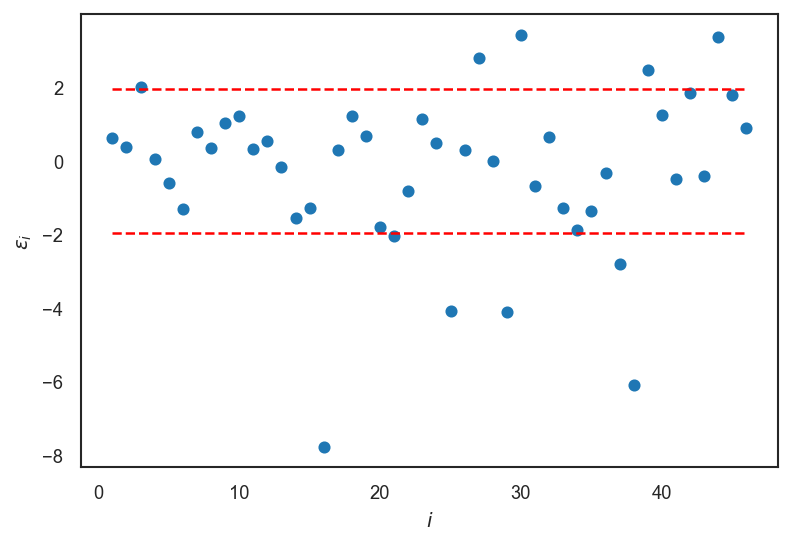

In [57]:
standardized_errors = (y_valid - y_valid_pred_mean) / y_valid_pred_std

fig, ax = plt.subplots(dpi=150)
i = np.arange(1, standardized_errors.shape[0] + 1)
# The standarized errors
ax.plot(i, standardized_errors, 'o', label='Standarized errors')
# The 97.5% quantile of the normal as a red dashed line
ax.plot(i, 1.96 * np.ones(standardized_errors.shape[0]), 'r--')
# The 2.5% quantile of the normal as a red dashed line
ax.plot(i, -1.96 * np.ones(standardized_errors.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

Quantile-quantile plot of the standardized errors.

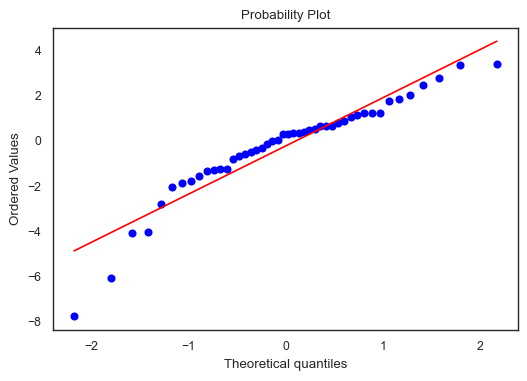

In [58]:
fig, ax = plt.subplots(dpi=100)
st.probplot(standardized_errors, dist=st.norm, plot=ax);

### Subpart B.II

What is the noise variance you estimated for the Power?

In [59]:
sigma = np.sqrt(1.0 / model.alpha_)
print('Noise variance            -> sigma = {0:1.2f} W'.format(sigma))

Noise variance            -> sigma = 16.26 W


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

**If you look at the precision plot shown in the diagnostics above, you can see that the 4th through 9th degree terms of the polynomial are not very important.** All the other terms in the polynomial are therefore important, because they have small precision values corresponding to their respective weights.

# Problem 3 - Explaining the challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced on the rubber O-rings which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propelant through the nozzles thus producing thrust).

It turns out that the performance of the O-ring material was particularly sensitive on the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google drive or run the code cell below).

In [60]:
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv'
# download(url)

Even though this is a csv file, you should load it with pandas because it contains some special characters.

In [61]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` is has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We are going to use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before we proceed to the analysis of the data, let's clean the data up.

First, we drop all the bad records:

In [62]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Just remember that the temperature the day of the Challenger accident was 31 degrees F.

In [63]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [64]:
x = clean_data['Temperature'].values
x

array([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70,
       81, 76, 79, 75, 76, 58])

In [65]:
y = clean_data['Damage Incident'].values.astype(np.float64)
y

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Do not bother doing a validation because there are not a lot of data.
Just use a very simple model so that you don't overfit.

**Let's just use logistic regression to fit a quadratic model. Hopefully, this will be simple enough to avoid overfitting.**

In [66]:
from sklearn.linear_model import LogisticRegression

def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

In [67]:
# Make the design matrix
degree = 2
Phi_linear = get_polynomial_design_matrix(x[:, None], degree)
model = LogisticRegression(penalty='none', fit_intercept=False).fit(Phi_linear, y)

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

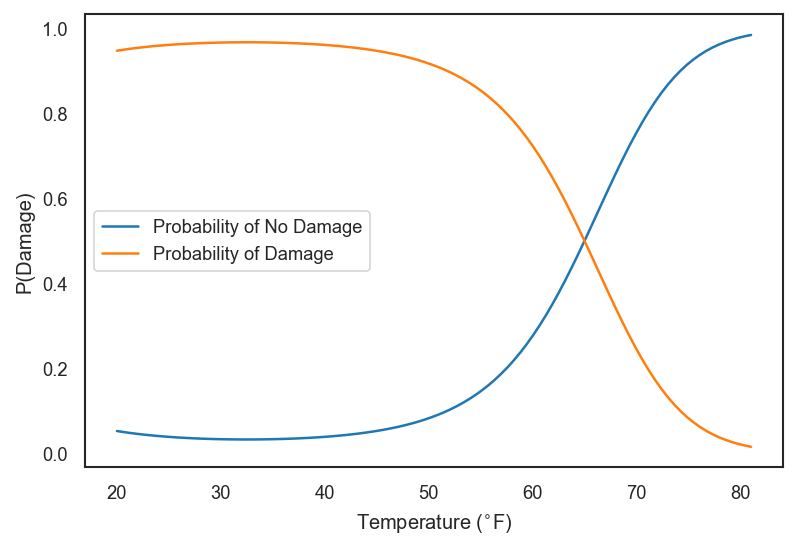

In [68]:
xs = np.linspace(20, x.max(), 100)
Phi_predict = get_polynomial_design_matrix(xs[:, None], degree)
y_predicted = model.predict_proba(Phi_predict)
y_predicted_prob_no_damage = y_predicted[:, 0]
y_predicted_prob_damage = y_predicted[:, 1]

plt.figure(dpi=150)
plt.plot(xs, y_predicted_prob_no_damage, label = 'Probability of No Damage')
plt.plot(xs, y_predicted_prob_damage, label = 'Probability of Damage')
plt.xlabel('Temperature ($^{\circ}$F)')
plt.ylabel('P(Damage)')
plt.legend(loc='best');

## Part C - Decide whether or not to launch

The temperature the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [69]:
challenger_temp = 31
Phi_challenger = np.array([1, challenger_temp, challenger_temp**2]).reshape(1, -1)
prob_challenger_damage = model.predict_proba(Phi_challenger)[0][1]
print('Probability of challenger launch damage (at 31 degrees F) = {0:1.2f}%'.format(prob_challenger_damage * 100))

Probability of challenger launch damage (at 31 degrees F) = 96.74%


**Let's assume that a false negative is 5x as bad as a false positive** (not predicting actual damage is 5x worse than not predicting actual no damage).

In [70]:
# c_00 = cost of correctly picking no damage when there is no damage
# c_01 = cost of wrongly picking no damage when there is damage
# c_11 = cost of correctly picking damage when there is damage
# c_10 = cost of wrongly picking damage when there is no damage
cost_matrix = np.array(
[[0.0, 3.0],
 [1.0, 0.0]]
)

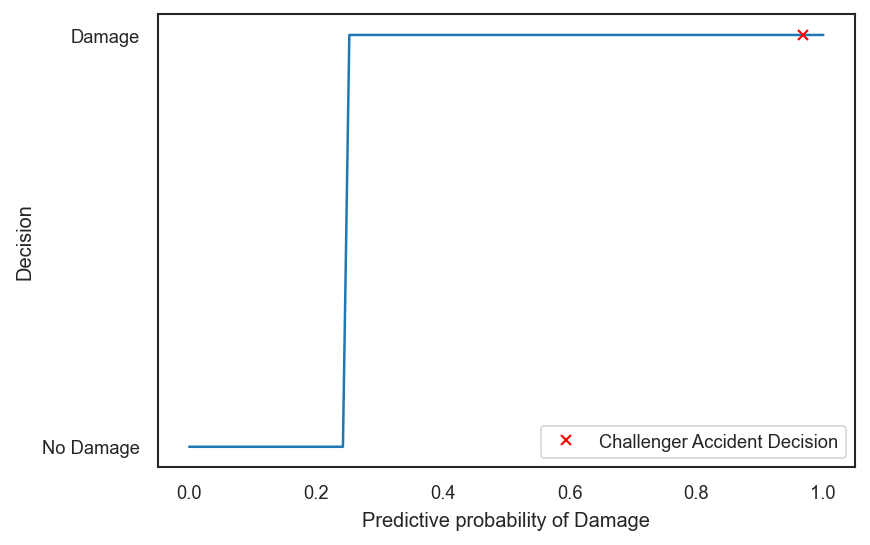

In [72]:
# calculate expected costs of decisions
pDamage = np.linspace(0, 1, 100)
pNoDamage = 1.0 - pDamage
damage_probabilities = np.hstack([pNoDamage[:, None], pDamage[:, None]])
expected_cost = np.einsum('ij,kj->ki', cost_matrix, damage_probabilities)

# plot optimal decisions based on chosen costs
fig, ax = plt.subplots(dpi=150)
decision_idx = np.argmin(expected_cost, axis=1)
ax.plot(pDamage, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Damage', 'Damage'])
ax.set_ylabel('Decision')
ax.set_xlabel('Predictive probability of Damage');
ax.plot([prob_challenger_damage], [1], 'rx', label='Challenger Accident Decision')
plt.legend(loc='best')

Plot the optimal decision as a function of the external temperature

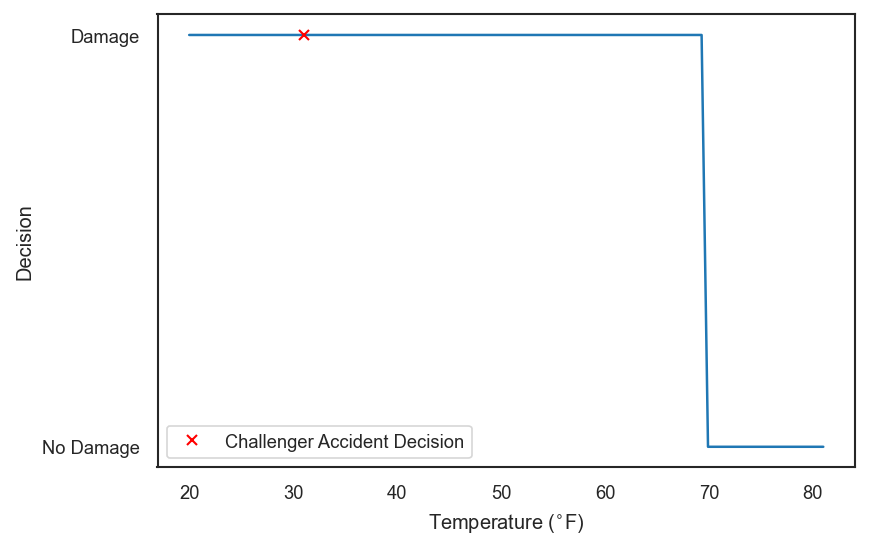

In [73]:
temperature_damage_probabilities = np.hstack([y_predicted_prob_no_damage[:, None], y_predicted_prob_damage[:, None]])
expected_cost = np.einsum('ij,kj->ki', cost_matrix, temperature_damage_probabilities)

# plot optimal decisions based on chosen costs
fig, ax = plt.subplots(dpi=150)
decision_idx = np.argmin(expected_cost, axis=1)
ax.plot(xs, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Damage', 'Damage'])
ax.set_ylabel('Decision')
ax.set_xlabel('Temperature ($^{\circ}$F)');
ax.plot(challenger_temp, [1], 'rx', label='Challenger Accident Decision')
plt.legend(loc='best')

**We can observe that the challenger accident occurred at a temperature that is much lower than our optimal decision making approach deems acceptable.**